# Preprocessing: Pipeline Setup
* Grayscale morphology: markers and masks
* Grayscale morphology: H-domes

In [1]:
using Pkg
Pkg.activate("../notebooks/calval/")
using Images
using IceFloeTracker
using CSV
using CairoMakie
using DataFrames
using Peaks

  Activating project at `~/Documents/research/calval_tgrs/notebooks/calval`
[ Info: Precompiling Images [916415d5-f1e6-5110-898d-aaa5f9f070e0] (cache misses: wrong dep version loaded (4), incompatible header (8), mismatched flags (2))
[ Info: Precompiling IceFloeTracker [04643c7a-9ac6-48c5-822f-2704f9e70bd3] (cache misses: wrong dep version loaded (6), incompatible header (8), mismatched flags (4))
[ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b] (cache misses: wrong dep version loaded (4), incompatible header (12), mismatched flags (2))
[ Info: Precompiling CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0] (cache misses: wrong dep version loaded (4), incompatible header (6))
[ Info: Precompiling GeometryBasicsGeoInterfaceExt [6ad0e2c3-ff64-53dc-bf66-960a4ddcb305] (cache misses: wrong dep version loaded (4), incompatible header (6))
[ Info: Precompiling PolynomialsMakieExt [6a4b1961-d857-5aa3-b7f6-fc7c46de29bb] (cache misses: wrong dep version loaded (4), incompatible he

In [2]:
include("../scripts/dev/filter_tiles.jl")
include("../scripts/dev/nonlinear_diffusion.jl")
include("../scripts/dev/validation_data.jl")
include("../scripts/dev/gradient_functions.jl")

[ Info: Precompiling CSVFiles [5d742f6a-9f54-50ce-8119-2520741973ca] (cache misses: wrong dep version loaded (6), incompatible header (6), mismatched flags (2))
[ Info: Precompiling DistributionsTestExt [ffbe0ea5-a612-5ff7-aaf5-cac02eef3019] (cache misses: wrong dep version loaded (2), incompatible header (6))


exponential, inverse_quadratic

In [ ]:
df = DataFrame(CSV.File("../data/validation_dataset_testtrain_split.csv"));
df_training = copy(df[df.training,:]);

clear_sky_training_cases = df_training[df_training.cloud_fraction_manual .< 0.25  .&& (df_training.visible_sea_ice .== "yes"), [:case_number, :satellite]];

  Activating project at `~/Documents/research/calval_tgrs/notebooks/calval`
[ Info: Precompiling IceFloeTracker [04643c7a-9ac6-48c5-822f-2704f9e70bd3] (cache misses: wrong dep version loaded (6), incompatible header (8), mismatched flags (4))
[ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b] (cache misses: wrong dep version loaded (4), incompatible header (12), mismatched flags (2))
[ Info: Precompiling CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0] (cache misses: wrong dep version loaded (4), incompatible header (6))
[ Info: Precompiling GeometryBasicsGeoInterfaceExt [6ad0e2c3-ff64-53dc-bf66-960a4ddcb305] (cache misses: wrong dep version loaded (4), incompatible header (6))
[ Info: Precompiling IntervalArithmeticRecipesBaseExt [e3b91bd4-2888-5303-85ed-4cf5ebb38ff1] (cache misses: wrong dep version loaded (4), incompatible header (6))
[ Info: Precompiling ArchGDALMakieExt [ed506d0f-917e-5ac5-847b-cce2fb23f093] (cache misses: wrong dep version loaded (4), incompatible h

# Parameters and cloud mask

In [4]:
using IceFloeTracker: AbstractCloudMaskAlgorithm
using IceFloeTracker: fill_holes

In [257]:
# Cases missed by the tile filter function:
# 16 Terra, where the clouds are thin enough to see all the floes. 


data_loader = Watkins2025GitHub(; ref="a451cd5e62a10309a9640fbbe6b32a236fcebc70")
dataset = data_loader(c -> c.case_number == 111 && c.satellite == "terra");
case = first(dataset);


┌ Warning: In /tmp/Watkins2025/a451cd5e62a10309a9640fbbe6b32a236fcebc70/validation_dataset.csv line 381 has 0 fields but 28 fields are expected. Skipping row.
└ @ TextParse ~/.julia/packages/TextParse/bX5Ws/src/csv.jl:390


In [266]:
cloud_mask_settings = (
    prelim_threshold=53.0/255.,
    band_7_threshold=130.0/255.,
    band_2_threshold=169.0/255.,
    ratio_lower=0.0,
    ratio_offset=0.0,
    ratio_upper=0.53
)

cmask = LopezAcostaCloudMask(cloud_mask_settings...)
tile_size_pixels = 200


@kwdef struct Watkins2025CloudMask <: AbstractCloudMaskAlgorithm
    prelim_threshold::Float64 = 0.21
    band_7_threshold::Float64 = 0.51
    band_2_threshold::Float64 = 0.66
    ratio_lower::Float64 = 0.0
    ratio_offset::Float64 = 0.0
    ratio_upper::Float64 = 0.53
    marker_strel = strel_box((7,7))
    opening_strel = strel_diamond((3,3))
end


# use functor notation to define a function using the parameter struct
function (f::Watkins2025CloudMask)(img::AbstractArray{<:Union{AbstractRGB,TransparentRGB}})
    init_cloud_mask = LopezAcostaCloudMask(f.prelim_threshold,
                                           f.band_7_threshold,
                                           f.band_2_threshold,
                                           f.ratio_lower,
                                           f.ratio_offset,
                                           f.ratio_upper)(img)
    markers = opening(init_cloud_mask, f.marker_strel)
    reconstructed = mreconstruct(dilate, markers, init_cloud_mask, f.opening_strel)
    smoothed = opening(reconstructed, f.opening_strel)
    filled = fill_holes(smoothed)
    return filled
end

# Updated unsharp mask
function unsharp_mask(
    img::AbstractArray{<:Union{AbstractRGB,TransparentRGB,AbstractGray}},
    radius::Real=2,
    amount::Real=0.4,
    threshold::Real=0.01)

    image_float = float64.(img)
    image_smoothed = imfilter(image_float, Kernel.gaussian(radius))

    cv_image = channelview(image_float)
    cv_smooth = channelview(image_smoothed)    
    diff = cv_image .- cv_smooth
    cv_sharp = cv_image .+ diff .* amount
    clamp!(cv_sharp, 0, 1)

    # # Convert back into an image of the original type
    sharpened_image = colorview(base_colorant_type(eltype(img)), cv_sharp)
    sharpened_image = convert.(eltype(img), sharpened_image)

    # Optionally use only where sharpening is larger than threshold
    diff_magnitude = length(size(diff)) > 2 ? dropdims(sqrt.(sum(diff.^2, dims=1)); dims=1) : abs.(diff)

    threshold > 0 && (sharpened_image[diff_magnitude .< threshold] .= img[diff_magnitude .< threshold])
    
    return sharpened_image
end

unsharp_mask (generic function with 4 methods)

[ Info: Diffuse and sharpen the full image


  0.089370 seconds (7.60 k allocations: 414.229 MiB, 13.90% gc time)
  0.003221 seconds (2.23 k allocations: 3.914 MiB)


[ Info: Histogram adjustment


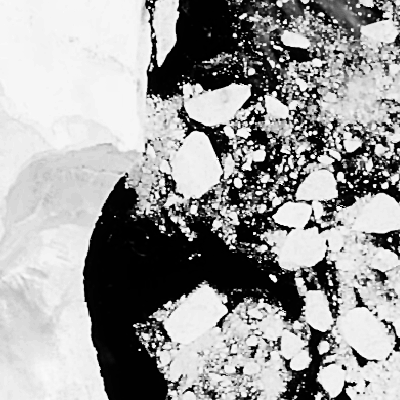

In [288]:
new_cmask = Watkins2025CloudMask();
pmd_diff = PeronaMalikDiffusion(0.1, 0.1, 5, "exponential")

tc_img = RGB.(case.modis_truecolor)
fc_img = RGB.(case.modis_falsecolor)

land_mask = IceFloeTracker.create_landmask(case.modis_landmask)
cloud_mask = IceFloeTracker.create_cloudmask(fc_img, Watkins2025CloudMask())
# Note: Application of masks results in haloes and artifacts with the histogram adjustment
# IceFloeTracker.apply_landmask!(tc_img, land_mask.non_dilated)
# IceFloeTracker.apply_landmask!(fc_img, land_mask.non_dilated)

# temp: reverse landmask
land_mask = (non_dilated = .!land_mask.non_dilated, dilated = .!land_mask.dilated)
tiles = IceFloeTracker.get_tiles(tc_img, tile_size_pixels) # Tile size of 200 --> 50 km

# Get list of tiles to process
filtered_tiles = filter(t -> filter_function(tc_img[t...],
                                             fc_img[t...],
                                             cloud_mask[t...],
                                             land_mask.dilated[t...]),
                        tiles)

# If desired, a mask can be made for the tiles included after filtering
tile_markers = zeros(size(cloud_mask))
for tile in filtered_tiles
    tile_markers[tile...] .= 1
end

@info "Diffuse and sharpen the full image"
# Image diffusion can be slow, so applying it only to the tiles in the filtered list
# speeds things up linearly (i.e. half the number of tiles takes half as long.)
# This does slightly change the result, as borders of tiles are not diffused.
tc_diffused_sharpened = deepcopy(tc_img)
@time begin
    for tile in filtered_tiles
        tc_diffused_sharpened[tile...] .= nonlinear_diffusion(deepcopy(tc_img)[tile...], pmd_diff) |> unsharp_mask
    end
end

@info "Histogram adjustment"
# Things to prevent issues: the rblocks and cblocks not result in cutting the image into too small of pieces.
# 50 km - 100 km block seems okay. Done on the whole image as the algorithm is rather fast.
rblocks, cblocks = round.(Int64, size(tc_img) ./ tile_size_pixels)
rblocks = maximum((1, rblocks))
cblocks = maximum((1, cblocks))

@time adjust_histogram!(tc_diffused_sharpened, AdaptiveEqualization(clip=0.99, rblocks=2, cblocks=2, nbins=64))

tc_gray = Gray.(tc_diffused_sharpened)
# Increase the range from dark to bright
adjust_histogram!(tc_gray, ContrastStretching(slope=3.5))

test = adjust_histogram(tc_gray, LinearStretching())

# Stretch from 0 to 1
# test = adjust_histogram(test, LinearStretching())
# # Adjust the histogram
# tc_diffused_sharpened .= tc_diffused_sharpened .* .! cloud_mask .* tile_markers

In [309]:
# Grayscale morphological operations
dilated_img = dilate(tc_gray, strel_diamond((3, 3)))
equalized_gray_sharpened_reconstructed = clamp.(mreconstruct(
    dilate, complement.(dilated_img), complement.(tc_gray), strel_diamond((3, 3))), 0, 1);


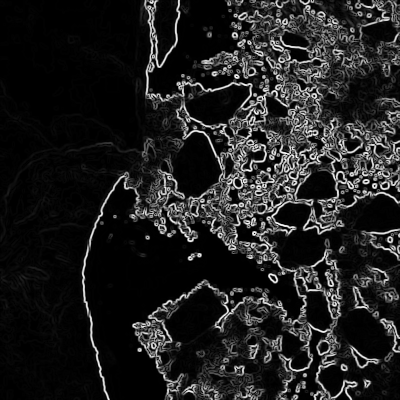

In [310]:
Gx, Gy = imgradients(equalized_gray_sharpened_reconstructed,  KernelFactors.sobel, "replicate")
gmag = hypot.(Gx, Gy)
gmag .= gmag ./ maximum(gmag)
Gray.(gmag)

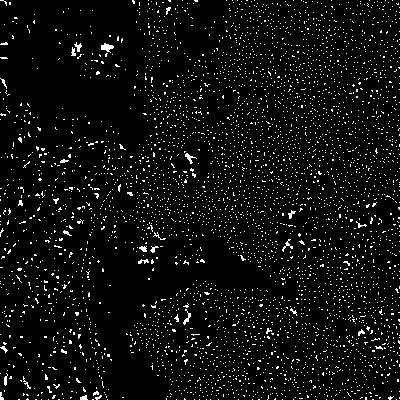

In [313]:
local_max = ImageMorphology.local_minima(equalized_gray_sharpened_reconstructed; connectivity=1) .> 0
Gray.(local_max)

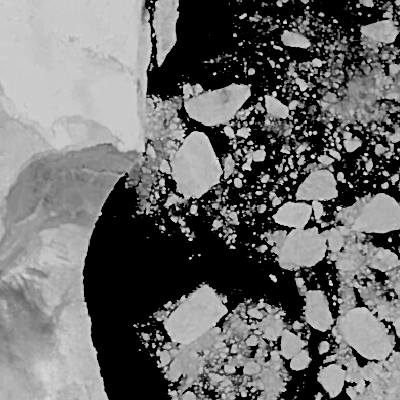

In [328]:
morphed_residue = dilate(Gray.(tc_img), strel_diamond((3,3))) .- equalized_gray_sharpened_reconstructed

In [344]:
using Random

segments = zeros(Int64, size(tc_img))
k = 5
for tile in filtered_tiles
    segments[tile...] = IceFloeTracker.kmeans_segmentation(float64.(morphed_residue[tile...]), k=k)
end
# Produce an image by replacing values inside a segment with the segment mean color
function view_seg(s)
    map(i->segment_mean(s,i), labels_map(s))
end
# Return a random color of type RGB{N0f8}
function get_random_color(seed)
    Random.seed!(seed)
    rand(RGB{N0f8})
end

# Produce an image by replacing values inside a segment with the segment mean color
function view_seg(s)
    map(i->segment_mean(s,i), labels_map(s))
end

# Assign random colors to each segment (useful if viewing cluster results)
function view_seg_random(s)
    map(i->get_random_color(i), labels_map(s))
end
tc_seg = SegmentedImage(morphed_residue, label_components(segments))

Segmented Image with:
  labels map: 400×400 Matrix{Int64}
  number of labels: 9624

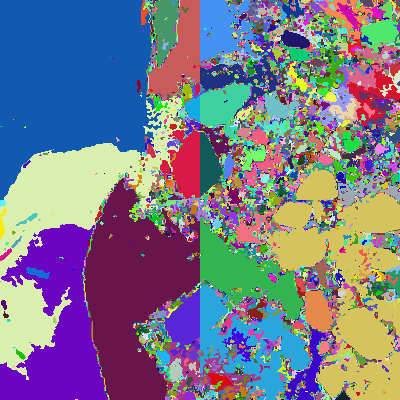

In [345]:
view_seg_random(tc_seg)

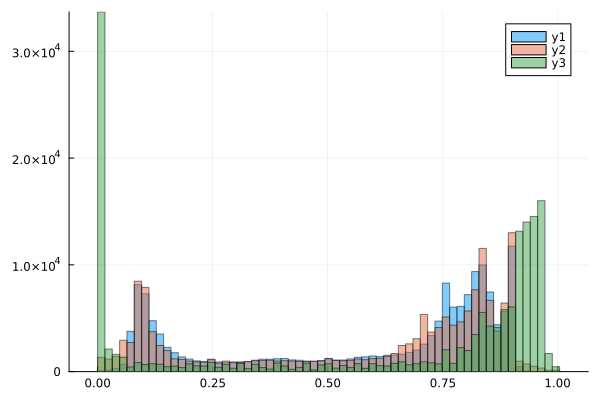

In [342]:
histogram(vec(Float64.(Gray.(tc_img))), bins=range(0, 256, 64) ./ 255, alpha=0.5)
histogram!(vec(Float64.(Gray.(tc_diffused_sharpened))), bins=range(0, 256, 64) ./ 255, alpha=0.5)
histogram!(vec(Float64.(Gray.(test))), bins=range(0, 256, 64) ./ 255, alpha=0.5)

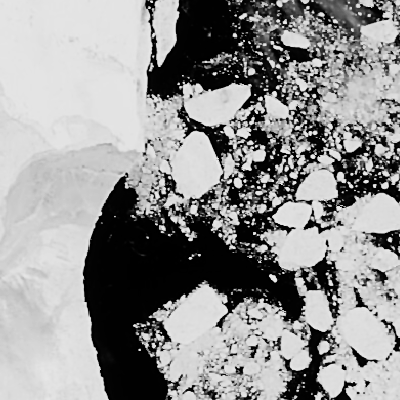

In [261]:
adjust_histogram(Gray.(tc_diffused_sharpened), ContrastStretching(slope=3.5))

In [217]:
tc_img = load("../../IceFloeTracker.jl/test/test_inputs/beaufort-chukchi-seas_truecolor.2020162.aqua.250m.tiff")
fc_img = load("../../IceFloeTracker.jl/test/test_inputs/beaufort-chukchi-seas_falsecolor.2020162.aqua.250m.tiff")
cloud_mask = IceFloeTracker.create_cloudmask(fc_img, new_cmask)
land_mask = IceFloeTracker.create_landmask(load("../../IceFloeTracker.jl/test/test_inputs/landmask.tiff"), strel_diamond((11,11)))
cloud_mask = cloud_mask .* land_mask.non_dilated;

In [218]:
tiles = IceFloeTracker.get_tiles(tc_img, 200)
tile_markers = zeros(size(cloud_mask))
filtered_tiles = filter(t -> filter_function(tc_img[t...], fc_img[t...], cloud_mask[t...], .!land_mask.dilated[t...]), tiles)
for tile in filtered_tiles
    tile_markers[tile...] .= 1
end

In [220]:
@time tc_diffused_sharpened_init = nonlinear_diffusion(deepcopy(tc_img), pmd_diff) |> unsharp_mask;

  0.078059 seconds (1.98 k allocations: 417.855 MiB, 5.08% gc time)


In [221]:
@time begin
    tc_diffused_sharpened2 = deepcopy(tc_img)
    for tile in filtered_tiles
        tc_diffused_sharpened2[tile...] .= nonlinear_diffusion(deepcopy(tc_img)[tile...], pmd_diff) |> unsharp_mask
    end
end

  0.093519 seconds (7.61 k allocations: 422.995 MiB, 7.15% gc time)


In [222]:
@time begin
    tc_diffused_sharpened = deepcopy(tc_img)
    for tile in tiles
        tc_diffused_sharpened[tile...] .= nonlinear_diffusion(deepcopy(tc_img)[tile...], pmd_diff) |> unsharp_mask
    end
end
nothing

  0.093710 seconds (7.61 k allocations: 422.995 MiB, 8.14% gc time)


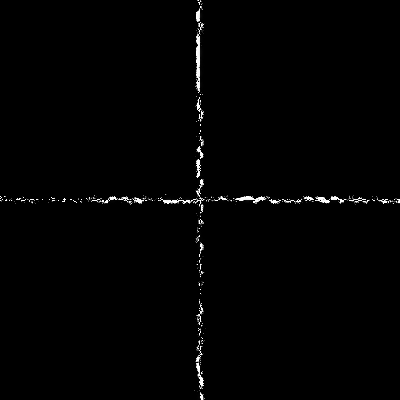

In [223]:
Gray.(abs.(tc_diffused_sharpened_init .- tc_diffused_sharpened))

In [224]:
maximum(abs.(Float64.(Gray.(tc_diffused_sharpened_init)) .- Float64.(Gray.(tc_diffused_sharpened))))

0.0784313725490196

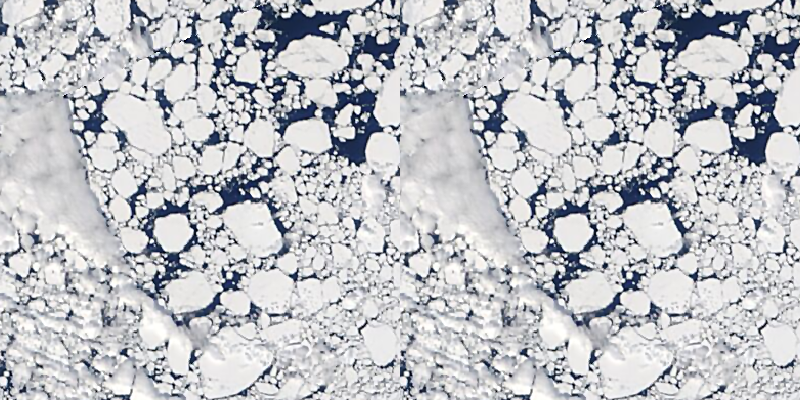

In [227]:
mosaicview(tc_diffused_sharpened_init, tc_diffused_sharpened, nrow=1)

In [196]:
length(tiles), length(filtered_tiles)

(902, 472)

  1.763934 seconds (2.23 M allocations: 1.356 GiB, 15.36% gc time, 16.94% compilation time)


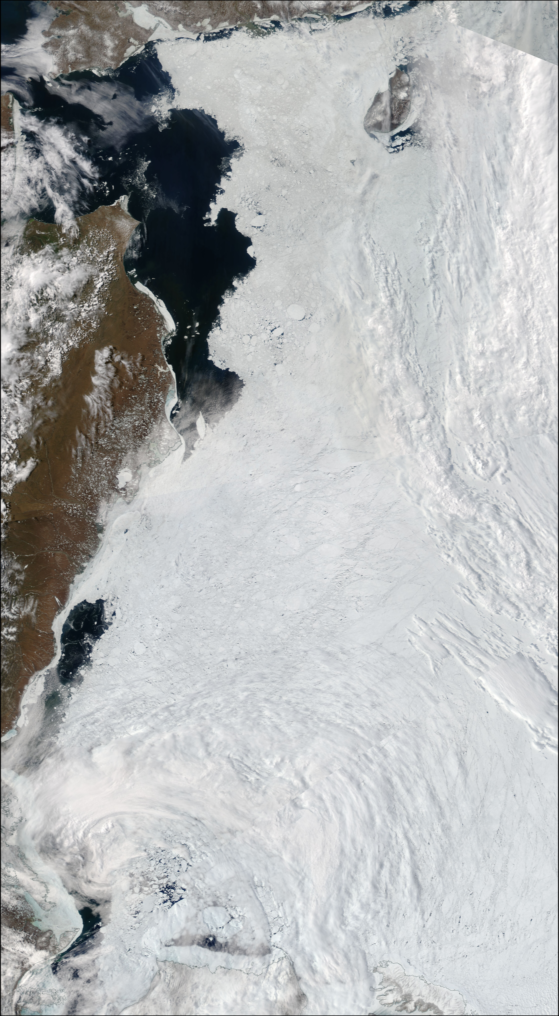

In [197]:
@time adjust_histogram(tc_diffused_sharpened, f)

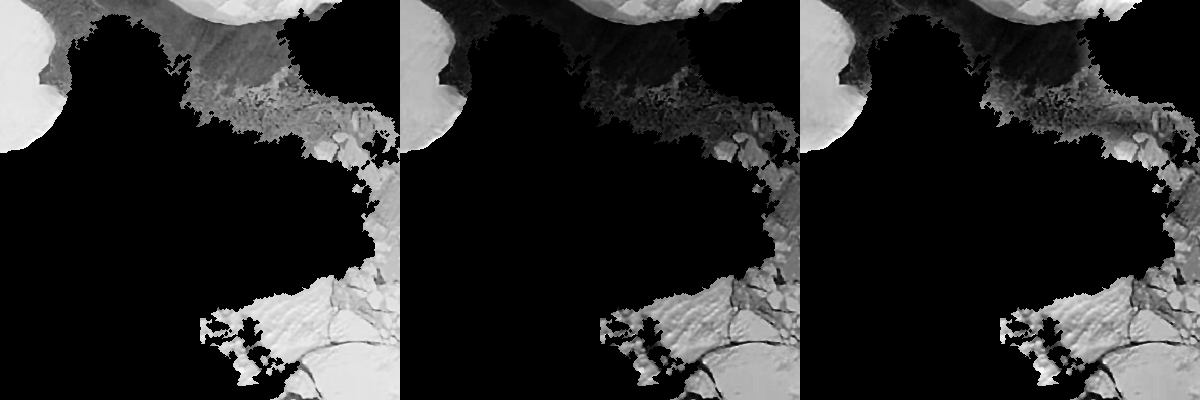

In [180]:
f = AdaptiveEqualization(;nbins=256, rblocks=8, cblocks=8, clip=0.99)
gc = GammaCorrection(gamma=3)
mosaicview(Gray.(tc_diffused_sharpened), adjust_histogram(Gray.(tc_diffused_sharpened), gc), 
    adjust_histogram(adjust_histogram(Gray.(tc_diffused_sharpened), gc), f), nrow=1)

In [138]:
# Reconstruction
# markers = closing(binarize(Gray.(tc_diffused_sharpened), AdaptiveThreshold(window_size=200, percentage=0)))
# reconstructed = mreconstruct(dilate, complement.(markers), complement.(Gray.(tc_diffused_sharpened)))
# # reconstructed = adjust_histogram(reconstructed, G())
# Gray.(tc_diffused_sharpened) .- reconstructed

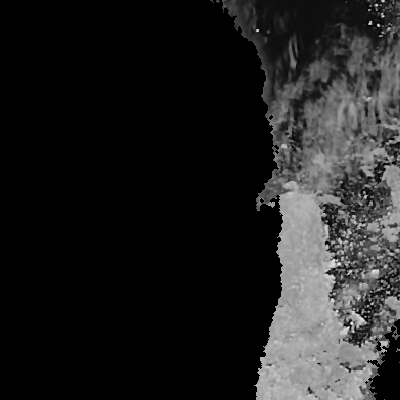

In [167]:
bin_img = opening(binarize(Gray.(tc_diffused_sharpened), AdaptiveThreshold(window_size=200, percentage=0)))
test = Gray.(tc_diffused_sharpened)
test[bin_img .== 0] .= 0.9 .* test[bin_img .== 0]
Gray.(test)

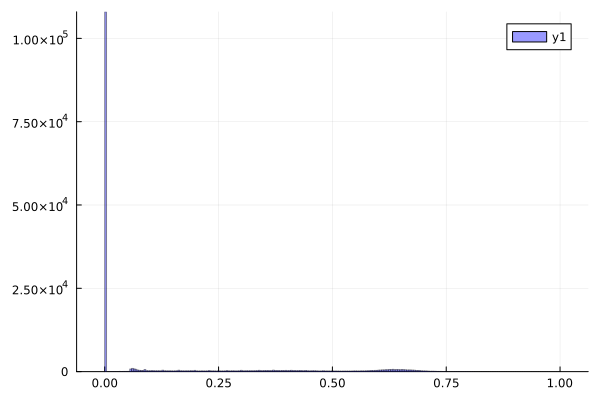

In [175]:
using Plots
bins = range(0, 1, 256)
histogram(vec(Float64.(test)), color=:blue, alpha=0.4, bins=bins)

# histogram!(vec(Float64.(adjust_histogram(Gray.(tc_diffused_sharpened), f))), color=:red, alpha=0.4, bins=bins)